In [1]:
## Integration of biopsies and organ donors from 2 studies
import anndata, numpy as np, pandas as pd, lpy, scanpy as sc, imp, re, rpy2
sc.logging.print_header()
%load_ext rpy2.ipython
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/scvi/__init__.py:31: DeprecationWarning: scvi is deprecated, please uninstall scvi via `pip uninstall scvi` and install the new scvi-tools package at github.com/YosefLab/scvi-tools
  warnings.warn(deprecation_msg, DeprecationWarning)


scanpy==1.6.0 anndata==0.7.5 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.22.2 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1 leidenalg==0.7.0


Create AnnData Object
def createAnnData(folderlist, prefix, souporcell_folderlist = None, souporcell_genodico = None, autoinclude=["percent_mito", "log2p1_count", "n_genes"], min_UMI_prefilter = None, min_cell_per_gene_allowed=3, min_gene_per_cell_allowed=500, sample_obskey = "sample_names",doqcplots=False, doinspect=False, mitogeneprefix="MT-", do_log2_normalize=True):
    if doinspect is True: print("\033Create AnnData Object\033\033"); print(inspect.getsource(createAnnData));print("\033Execution:\033")
    adatas = []
    def pickname(x,y):
        if (y == "singlet"): return("_genotype_" +str(x))
        else: return("_doublet")
    def pickname2(x,y,z):
        if (y == "singlet"): return(z[int(x)])
        else: return("doublet")
    for i in range(len(folderlist)):
        print("Processing " + prefix[i])
        adatas.append(sc.read_10x_mtx(folderlist[i]))
        print(adatas[-1].X.shape)
        if min_UMI_prefilter is not None: sc.pp.filter_cells(adatas[-1], min_counts= min

... storing 'sample_names' as categorical


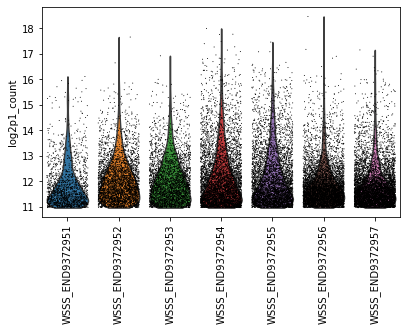

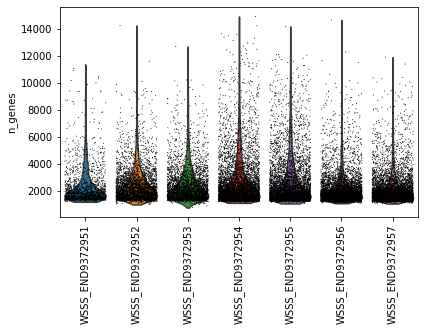

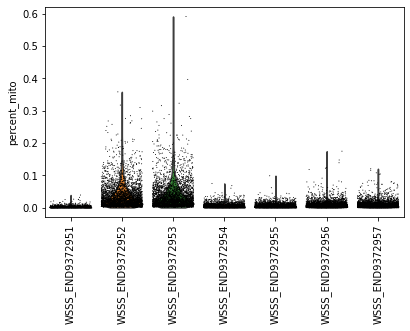

In [2]:
# Set some constants
meta = pd.read_csv("./sample_meta.tsv",sep='\t')
samplelist = meta["sample_names"]
folderlist = ["/lustre/scratch117/cellgen/team292/lh20/revision/unfiltered/" + meta["FolderName"][i] + "/" for i in range(meta.shape[0])]

#Load data
adata = lpy.createAnnData(folderlist, samplelist, min_UMI_prefilter = 2000, doqcplots=True, doinspect=True)

In [3]:
#add metadata from data table
adata = lpy.addMetadata(adata, meta, "sample_names", "FolderName", doinspect=True)

Add metadata from sample table to anndata
def addMetadata(adata, metadata, obs_key, meta_key, doinspect=False):
    if doinspect is True: print("\033Add metadata from sample table to anndata\033\033"); print(inspect.getsource(addMetadata));print("\033Execution:\033")
    aslist = metadata[meta_key].tolist()
    rowmap = {i : aslist.index(i)  for i in aslist}
    for val in metadata.columns:
        if val != meta_key:
            aslist = metadata[val].tolist()
            adata.obs[val] = [aslist[rowmap[i]] for i in adata.obs[obs_key] ]
    return adata;

Execution:


In [4]:
obskey_filteredcells = "filtered_cells"
adata = lpy.scrub(adata, "sample_names",obskey_cellfilter= obskey_filteredcells,add_cell_filter={"max_percent_mito": 0.15, "scrublet_local_pred": False}, doinspect=True)

Detect Doublets and defining cells to filter
def scrub(adata, batch_obsattrib, bonf_threshold = 0.01, add_qc_metrics=False,mito_prefix= "MT-", obskey_cellfilter = "filtered_cells", add_cell_filter={"max_percent_mito": 0.15, "scrublet_local_pred": False}, doinspect=False):
    if doinspect is True: print("\033Detect Doublets and defining cells to filter\033\033"); print(inspect.getsource(scrub));print("\033Execution:\033")
    
    import scrublet as scr
    import scanpy as sc
    print("spliting data using attribute " + batch_obsattrib)
    adatas = splitAnnData(adata, batch_obsattrib)

    if (add_qc_metrics):
        mito_genes = [name for name in adata.var_names if name.startswith(mito_prefix)]
        adata.obs['log2p1_RNA_count'] = np.log1p(adata.X.sum(axis=1).A1) / math.log(2)
        adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

    dalist = list(adata.obs_names)
    tmap = {}
    for i in range(len(adata.obs_names)):
      

In [5]:
# Prooject cell only primary tissue data
adata_primary = anndata.read_h5ad("../primary/N6-integrated_donors.h5ad")
res = lpy.doLogisticRegression(adata, adata_primary, "fine_celltypes", cell_filter_src = [ x not in ["filtered"] for x in  adata_primary.obs["fine_celltypes"] ], cc_gene_filter_prefix = "",make_circular_coords =True, cosine_coor_softmax_coef = 15.0, genespeficityfraction = 0.5, C_parameter = 0.01, doinspect=True)

Logisitic regression based projection
def doLogisticRegression(adata, adata_ref, annotation_src, annotation_trg = None, annotation_trg_prob = None, cell_filter_trg = None, cell_filter_src = None, regr_max_iter = 10000, use_variable_genes=True, use_variable_genes_within_subset=True,  cc_gene_filter_prefix= None, use_raw_data=True, use_max_normalization=True, do_compute_cosine_distance=True, filtered_label = "filtered", make_circular_coords=False, cosine_coor_softmax_coef= None, logistic_coor_softmax_coef = None, C_parameter = 1, genespeficityfraction=None, doinspect=False):
    """Compute Logistic regression based projection

    Parameters
    ----------
    adata : Annadata.anndata
        Object containing the cells that are projected
    adata_ref: Annadata.anndata
        Object containing the reference cells that are defining classes used for the projection
    annotation_src : string
        must be in adata_ref.obs.keys(), annotation to project
    annotation_trg : string, optio

In [6]:
res = lpy.doLogisticRegression(adata, adata_primary, "broad_celltypes", cell_filter_src = [ x not in ["filtered"] for x in  adata_primary.obs["fine_celltypes"] ], cc_gene_filter_prefix = "",make_circular_coords =True, cosine_coor_softmax_coef = 15.0, genespeficityfraction = 0.5, C_parameter = 0.01)

Computing Variable genes within subset
excluding prior cell cycle genes from 3126 variable genes
Filtering gene heuristic
filtered down to 1548 genes
Subsetting objects using 1548 genes
Normalizing from raw data
training set has 73926 cells and test set has 29920 cells
Computing Centroids for Cosine distances
Compute Cosine distances
Learning classes
Projecting labels
Storing results


In [7]:
adata.write_h5ad("N1-nuclei.h5ad")

... storing 'sample_names' as categorical
... storing 'DonorID' as categorical
... storing '10x Kit' as categorical
... storing 'Treatment' as categorical
... storing 'Batch' as categorical
... storing 'Hormones' as categorical
... storing 'Inhibitor' as categorical


In [8]:
#used rply to transferm sparse matrix to R
spx = rpy2.robjects.FloatVector(adata.raw.X.data)
spp = rpy2.robjects.IntVector(adata.raw.X.indptr)
spi = rpy2.robjects.IntVector(adata.raw.X.indices)
spo = adata.obs
spv = adata.var

In [9]:
%%R -i spx -i spp -i spi -i spo -i spv -o spox -o spop -o spoi
library(SingleCellExperiment)
library(Matrix)
source("~/Rcode.R")
rawdata <- Matrix(0, max(spi)+1, length(spp) -1, sparse=T)
rawdata@x = spx
rawdata@i = as.integer(spi)
rawdata@p = as.integer(spp)
rownames(rawdata) = rownames(spv)
colnames(rawdata) = rownames(spo)
sce <- SingleCellExperiment(rawdata)
names(assays(sce)) <- c("rawdata")
for(i in colnames(spo)) {colData(sce)[i] <- spo[[i]]}
for(i in colnames(spv)) {rowData(sce)[i] <- spv[[i]]}

samples <- names(table(spo$sample_names))
print(samples)
library(celda)
denoisedmatrix <- Matrix(0, max(spi)+1,length(spp) -1, sparse=T)
for(i in samples){
    print(paste("Processing", i, "with", sum(spo$sample_names == i),"cells"))
	submat <- as.matrix(rawdata[, (spo$sample_names == i)])
    print(dim(submat))
	mode(submat) <- "integer" ; res <- decontX(submat)
	denoisedmatrix[, spo$sample_names == i] = res$resList$estNativeCounts
    print("saving partial")
    saveRDS(denoisedmatrix,"denoised.rds")
}
denoisedmatrix@x <- floor(denoisedmatrix@x) + (runif(length(denoisedmatrix@x)) < (denoisedmatrix@x %% 1) ) # sample fractionnal counts to integers
denoisedmatrix <- t(denoisedmatrix) # transpose
spox <- denoisedmatrix@x
spoi <- denoisedmatrix@i
spop <- denoisedmatrix@p

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, 

[1] "WSSS_END9372951" "WSSS_END9372952" "WSSS_END9372953" "WSSS_END9372954" "WSSS_END9372955" "WSSS_END9372956" "WSSS_END9372957"


R[write to console]: 
Attaching package: ‘celda’


R[write to console]: The following object is masked from ‘package:S4Vectors’:

    params




[1] "Processing WSSS_END9372951 with 1596 cells"
[1] 27026  1596


R[write to console]: --------------------------------------------------

R[write to console]: Start DecontX. Decontamination

R[write to console]: --------------------------------------------------

R[write to console]: --------------------------------------------------

R[write to console]: Completed DecontX. Total time: 50.4552 mins

R[write to console]: --------------------------------------------------



[1] "saving partial"
[1] "Processing WSSS_END9372952 with 3370 cells"
[1] 27026  3370


R[write to console]: --------------------------------------------------

R[write to console]: Start DecontX. Decontamination

R[write to console]: --------------------------------------------------

R[write to console]: --------------------------------------------------

R[write to console]: Completed DecontX. Total time: 1.750661 hours

R[write to console]: --------------------------------------------------



[1] "saving partial"
[1] "Processing WSSS_END9372953 with 3137 cells"
[1] 27026  3137


R[write to console]: --------------------------------------------------

R[write to console]: Start DecontX. Decontamination

R[write to console]: --------------------------------------------------

R[write to console]: --------------------------------------------------

R[write to console]: Completed DecontX. Total time: 1.607409 hours

R[write to console]: --------------------------------------------------



[1] "saving partial"
[1] "Processing WSSS_END9372954 with 5133 cells"
[1] 27026  5133


R[write to console]: --------------------------------------------------

R[write to console]: Start DecontX. Decontamination

R[write to console]: --------------------------------------------------

R[write to console]: --------------------------------------------------

R[write to console]: Completed DecontX. Total time: 2.788794 hours

R[write to console]: --------------------------------------------------



[1] "saving partial"
[1] "Processing WSSS_END9372955 with 4838 cells"
[1] 27026  4838


R[write to console]: --------------------------------------------------

R[write to console]: Start DecontX. Decontamination

R[write to console]: --------------------------------------------------

R[write to console]: --------------------------------------------------

R[write to console]: Completed DecontX. Total time: 2.624595 hours

R[write to console]: --------------------------------------------------



[1] "saving partial"
[1] "Processing WSSS_END9372956 with 5651 cells"
[1] 27026  5651


R[write to console]: --------------------------------------------------

R[write to console]: Start DecontX. Decontamination

R[write to console]: --------------------------------------------------

R[write to console]: --------------------------------------------------

R[write to console]: Completed DecontX. Total time: 3.106554 hours

R[write to console]: --------------------------------------------------



[1] "saving partial"
[1] "Processing WSSS_END9372957 with 6195 cells"
[1] 27026  6195


R[write to console]: --------------------------------------------------

R[write to console]: Start DecontX. Decontamination

R[write to console]: --------------------------------------------------

R[write to console]: --------------------------------------------------

R[write to console]: Completed DecontX. Total time: 3.415008 hours

R[write to console]: --------------------------------------------------



[1] "saving partial"
[1] "filtered 27228679 out of 172267684 UMI by denoising"


In [10]:
# replace normalized and raw data
from scipy import sparse
denoised_mat = sparse.csc_matrix((spox, spoi, spop), shape=adata.X.shape )
denoised_mat.eliminate_zeros() # some counts might have been down sampled to 0
denoised_mat = denoised_mat.tocsc()
adata = anndata.AnnData(denoised_mat, obs = adata.obs, var = adata.var)
adata.raw = adata.copy()
adata.X = np.log1p(adata.X) / math.log(2)

In [11]:
adata.write_h5ad("N1-denoised-nuclei.h5ad")